# Cluster genes along pseudotime 

Summary of time series clustering in R  
https://journal.r-project.org/archive/2016/RJ-2016-058/index.html  
https://cran.r-project.org/web/packages/dtwclust/vignettes/dtwclust.pdf  

### Distance meassures 

Shape meassures: Lock-step (n=m) and elastic (n!=m)  
Feature based: Fourier or wavelet coefficients, autocorrelation values, etc.  
Structure-based: (i) model-based approaches, where a model is fit to each series and the comparison is made between models, and (ii) complexity-based models, where the similarity between two series is measured based on the quantity of shared information.  
Prediction-based distances analyze the similarity of the forecasts obtained for different time series.  

In [63]:
options(warn=-1)
options(dplyr.summarise.inform=FALSE)

In [64]:
library_load <- suppressMessages(
    
    list(
        
        # parallelDist
        library(parallelDist), 
        
        # TradeSeq
        library(tradeSeq), 
        
        # Seurat 
        library(Seurat), 
        
        # GSEA
        library(fgsea), 
        library(msigdbr), 
        
        # Data 
        library(tidyverse), 
        
        # Plotting 
        library(ggplot2), 
        library(patchwork), 
        library(ggplotify),
        library(ComplexHeatmap),
        library(circlize)
        
    )
)

In [65]:
random_seed <- 42
set.seed(random_seed)

In [66]:
# Set working directory to project root
setwd("/research/peer/fdeckert/FD20200109SPLENO")

In [67]:
# Source files
source("plotting_global.R")
source("bin/tradeseq.R")
# source("bin/gsea.R")

In [68]:
# Plotting Theme
ggplot2::theme_set(theme_global_set(size_select=1)) # From project global source()

# Parameter settings and data import 

In [69]:
tradeseq_eb <- readRDS("result/lineage/ery_gam.rds")
ptg_eb <- readRDS("result/lineage/ery_ptg.rds")

# Get smooth counts and scale

In [134]:
n_points <- 15

In [135]:
cnt_log <- predictSmooth(tradeseq_eb[["fitgam"]], rownames(tradeseq_eb[["fitgam"]]), nPoints=n_points, tidy=TRUE)
cnt_log$time <- paste0("lineage_", cnt_log$lineage, ":", cnt_log$condition, ":", cnt_log$time)

# Prepare data for each condition 
cnt_log_nacl <- cnt_log[cnt_log$condition=="Baseline", ]
cnt_log_cpg <- cnt_log[cnt_log$condition=="CpG", ]

cnt_log_nacl <- tidyr::spread(cnt_log_nacl, key=time, value=yhat)
cnt_log_cpg <- tidyr::spread(cnt_log_cpg, key=time, value=yhat)

cnt_log_nacl <- dplyr::select(cnt_log_nacl, -lineage, -condition)
cnt_log_cpg <- dplyr::select(cnt_log_cpg, -lineage, -condition)

cnt_log_nacl <- column_to_rownames(cnt_log_nacl, "gene")
cnt_log_cpg <- column_to_rownames(cnt_log_cpg, "gene")

cnt_scale_nacl <- t(scale(t(cnt_log_nacl))) # Scale per condition for background distribution 
cnt_scale_cpg <- t(scale(t(cnt_log_cpg)))   # Scale per condition for background distribution 

# Combine data 
cnt_log <- cbind(cnt_log_nacl, cnt_log_cpg)
cnt_scale <- t(scale(t(cnt_log)))

In [136]:
# Correct PTAG NA for filtering 
ptg_eb$ptag_nacl <- ifelse(is.na(ptg_eb$ptag_nacl), FALSE, ptg_eb$ptag_nacl)
ptg_eb$ptag_cpg <- ifelse(is.na(ptg_eb$ptag_cpg), FALSE, ptg_eb$ptag_cpg)

In [137]:
genes_ptag <- rownames(ptg_eb[ptg_eb$ptag_nacl | ptg_eb$ptag_cpg, ]) # Select PTAG genes. The list is also used for ORA 

In [138]:
cnt_log_ptag <- cnt_log[genes_ptag, ]
cnt_scale_ptag <- cnt_scale[genes_ptag, ]

# Pseudotime perturbed genes (PTPG) 

## Generate background distribution per condition to estimate mean and sd of the Euclidean distance from similar behaving genes in cluster

In [139]:
cnt_scale_ptag_nacl <- cnt_scale_nacl[rownames(ptg_eb[ptg_eb$ptag_nacl, ]), ]
cnt_scale_ptag_cpg <- cnt_scale_cpg[rownames(ptg_eb[ptg_eb$ptag_cpg, ]), ]

In [140]:
dist_method <- "euclidean"

In [141]:
dist_ptag_nacl <- parallelDist::parDist(cnt_scale_ptag_nacl, method=dist_method)
dist_ptag_cpg <- parallelDist::parDist(cnt_scale_ptag_cpg, method=dist_method)

In [142]:
hclust_method <- "ward.D"

In [143]:
hclust_ptag_nacl <- hclust(dist_ptag_nacl, hclust_method)
hclust_ptag_cpg <- hclust(dist_ptag_cpg, hclust_method)

In [144]:
k_ptag_nacl <- 6
k_ptag_cpg <- 6

In [145]:
elbow_wcss_plot <- function(scale_data, hclust_result, cluster_k=25, cluster_k_thr=15, title="Elbow plot") {

    cluster_k <- 1:cluster_k
    wcss_k <- c()

    for(k in cluster_k) {
        
        cluster_i <- cutree(hclust_result, k)
        wcss_i <- c()
            
        for(i in unique(cluster_i)) {
            
                x <- scale_data[which(cluster_i==i), , drop=FALSE]
                wcss <- (nrow(x)-1)*sum(apply(x, 2, var))
                if(is.na(wcss)) {wcss=0}
                wcss_i[i] <- wcss

        }

        wcss_k[k] <- sum(wcss_i)

    }
    
    elbow_wcss_plot <- ggplot(data.frame(wcss=wcss_k, cluster_k=cluster_k), aes(x=cluster_k, y=wcss)) + 
        geom_line(size=1) + 
        geom_point(size=3, shape=21, fill="black", color="white") + 
        geom_vline(xintercept=cluster_k_thr, color="red", linetype="longdash") + 
        xlab("Number of Clusters") + ylab("Within groups sum of squares") + ggtitle(title)

    return(elbow_wcss_plot)


}

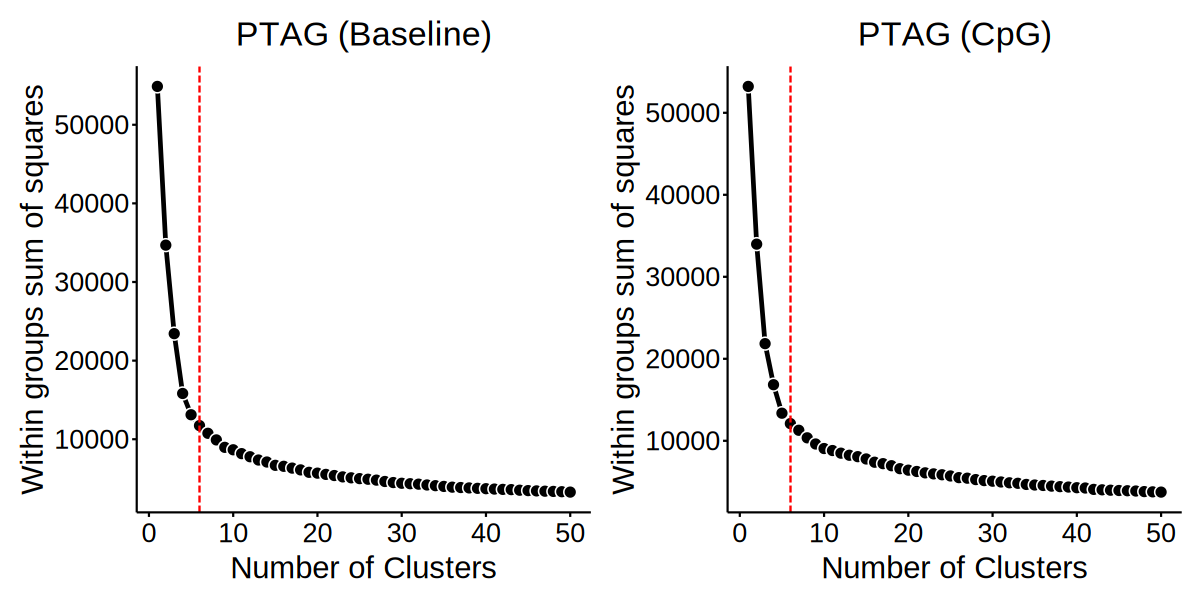

In [146]:
options(repr.plot.width=10, repr.plot.height=5)

elbow_wcss_plot(cnt_scale_ptag_nacl, hclust_ptag_nacl, 50, k_ptag_nacl, title="PTAG (Baseline)") + 
elbow_wcss_plot(cnt_scale_ptag_cpg, hclust_ptag_cpg, 50, k_ptag_cpg, title="PTAG (CpG)") + 
patchwork::plot_layout(ncol=2)

In [147]:
cluster_dist <- function(cnt_scale, hclust, k=10) {
    
    cluster_label <- cutree(hclust, k)
    cluster_label_unique <- unique(cluster_label)[order(unique(cluster_label))]

    cluster_dist <- list()
    for(cluster_label_i in cluster_label_unique) {

        cnt_scale_i <- cnt_scale[which(cluster_label==cluster_label_i), , drop=FALSE] # Can output single row matrix which produces NaN in parDist
        dist_i <- parallelDist::parDist(cnt_scale_i, method=dist_method)

        cluster_dist[[cluster_label_i]] <- data.frame(

            cluster=cluster_label_i, 
            dist=mean(dist_i), 
            dist_norm=mean(dist_i^(1/3))

        )

    }
    
    cluster_dist <- do.call("rbind", cluster_dist)
    
    return(cluster_dist)
   
}

In [148]:
cluster_dist_ptag_nacl <- cluster_dist(cnt_scale_ptag_nacl, hclust_ptag_nacl, k=k_ptag_nacl)
cluster_dist_ptag_cpg <- cluster_dist(cnt_scale_ptag_cpg, hclust_ptag_cpg, k=k_ptag_cpg)

In [149]:
cluster_dist_condition <- data.frame(dist_norm=c(cluster_dist_ptag_nacl$dist_norm, cluster_dist_ptag_cpg$dist_norm), treatment=c(rep("nacl", nrow(cluster_dist_ptag_nacl)), rep("CpG", nrow(cluster_dist_ptag_cpg))))
cluster_dist_condition <- na.omit(cluster_dist_condition)

## PTPG scoring for each gene between conditions 

In [150]:
dist <- lapply(1:length(genes_ptag), function(i) {parallelDist::parDist(list(cnt_scale_ptag[i, 1:n_points, drop=FALSE], cnt_scale_ptag[i, (n_points+1):(2*n_points), drop=FALSE]), method=dist_method)})
ptpg <- data.frame(gene=rownames(cnt_scale_ptag), dist=do.call("c", dist))

ptpg$dist_norm <- ptpg$dist^(1/3)

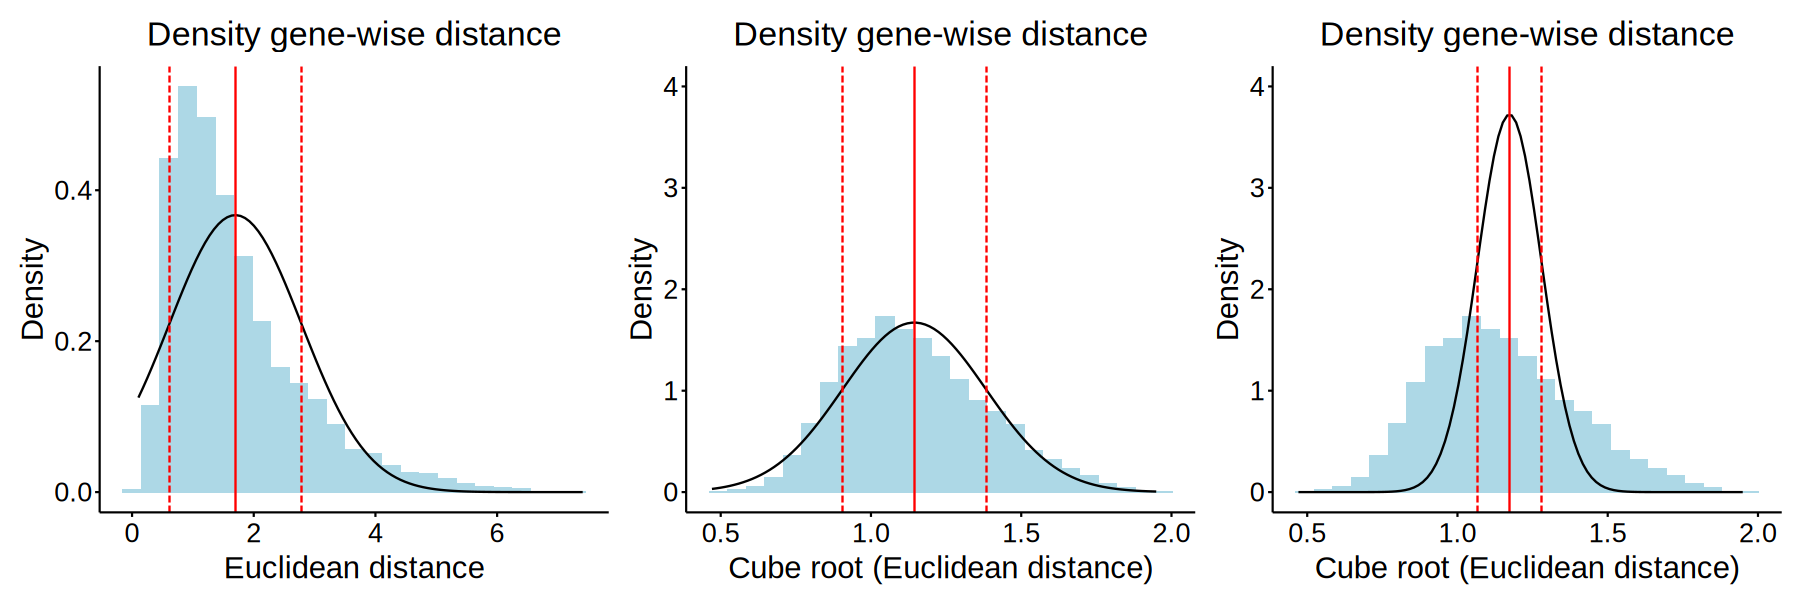

In [151]:
options(repr.plot.width=15, repr.plot.height=5)

histo_plot_1 <- ggplot(ptpg, aes(x=dist)) + 
    geom_histogram(aes(y=..density..), bins=25, fill="lightblue") + 
    stat_function(fun=dnorm, args=list(mean=mean(ptpg$dist), sd=sd(ptpg$dist))) + 
    geom_vline(xintercept=mean(ptpg$dist), color="red") + 
    geom_vline(xintercept=c(mean(ptpg$dist)-sd(ptpg$dist), mean(ptpg$dist)+sd(ptpg$dist)), color="red", linetype="longdash") + 
    xlab("Euclidean distance") + ylab("Density") + ggtitle("Density gene-wise distance") 

histo_plot_2 <- ggplot(ptpg, aes(x=dist_norm)) + 
    geom_histogram(aes(y=..density..), bins=25, fill="lightblue") + 
    ylim(c(0, 4)) + 
    stat_function(fun=dnorm, args=list(mean=mean(ptpg$dist_norm), sd=sd(ptpg$dist_norm))) + 
    geom_vline(xintercept=mean(ptpg$dist_norm), color="red") + 
    geom_vline(xintercept=c(mean(ptpg$dist_norm)-sd(ptpg$dist_norm), mean(ptpg$dist_norm)+sd(ptpg$dist_norm)), color="red", linetype="longdash") + 
    xlab("Cube root (Euclidean distance)") + ylab("Density") + ggtitle("Density gene-wise distance")

histo_plot_3 <- ggplot(ptpg, aes(x=dist_norm)) + 
    geom_histogram(aes(y=..density..), bins=25, fill="lightblue") + 
    ylim(c(0, 4)) + 
    stat_function(fun=dnorm, args=list(mean=mean(cluster_dist_condition$dist_norm), sd=sd(cluster_dist_condition$dist_norm))) + 
    geom_vline(xintercept=mean(cluster_dist_condition$dist_norm), color="red") + 
    geom_vline(xintercept=c(mean(cluster_dist_condition$dist_norm)-sd(cluster_dist_condition$dist_norm), mean(cluster_dist_condition$dist_norm)+sd(cluster_dist_condition$dist_norm)), color="red", linetype="longdash") + 
    xlab("Cube root (Euclidean distance)") + ylab("Density") + ggtitle("Density gene-wise distance")

histo_plot_1 + histo_plot_2 + histo_plot_3 + plot_layout(ncol=3)

In [152]:
ptpg$p_value=pnorm(ptpg$dist_norm, mean=mean(cluster_dist_condition$dist_norm), sd=sd(cluster_dist_condition$dist_norm), lower.tail=FALSE)
ptpg$fdr=p.adjust(ptpg$p_value, method="fdr")

ptpg$ptpg <- ifelse(ptpg$fdr<=0.01, TRUE, FALSE)

table(ptpg$ptpg)


FALSE  TRUE 
 6456   539 

## PCA of per-gene Euclidean distance 

In [153]:
pca_ptag <- stats::prcomp(cnt_scale_ptag[, 1:n_points]-cnt_scale_ptag[, (n_points+1):(2*n_points)], center=FALSE, scale=FALSE)

In [154]:
screen_plot <- function(pca_result) {
    
    screen_data=data.frame(pc=1:length(pca_result$sdev), var_explained=pca_result$sdev^2 / sum(pca_result$sdev^2))
    screen_plot <- ggplot(screen_data, aes(x=pc, y=var_explained)) + 
        geom_line(size=1) + 
        geom_point(size=3, shape=21, fill="black", color="white") + 
        xlim(1, 10) + 
        xlab("Principal Component") + ylab("Variance Explained") + ggtitle("Scree Plot") + 
        theme(
            aspect.ratio=1, 
            legend.position="none"
        )
    
    return(screen_plot)
    
}

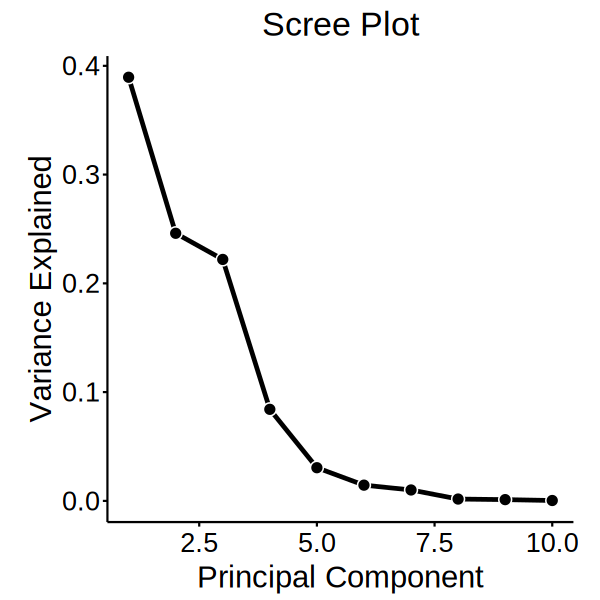

In [155]:
options(repr.plot.width=5, repr.plot.height=5)

screen_plot_ptag <- screen_plot(pca_ptag)
screen_plot_ptag

In [156]:
pca_plot <- function(pca_result, pc_1=1, pc_2=pc_1+1) {
    
    pca_data <- cbind(as.data.frame(pca_result$x), ptpg)
    
    pca_plot <- ggplot(pca_data, aes_string(x=paste0("PC", pc_1), y=paste0("PC", pc_2), fill="ptpg")) + 
        geom_point(size=3, shape=21, alpha=0.3, color="white") + 
        scale_fill_manual(values=c("TRUE"="gray", "FALSE"="darkblue")) + 
        theme(
            aspect.ratio=1, 
            legend.position="bottom"
        ) + 
        
        guides(fill = guide_legend(override.aes = list(alpha = 1)))
    
    return(pca_plot)
    
}

In [157]:
pca_plot_ptag <- lapply(1:10, function(i) {pca_plot(pca_ptag, pc_1=i)})

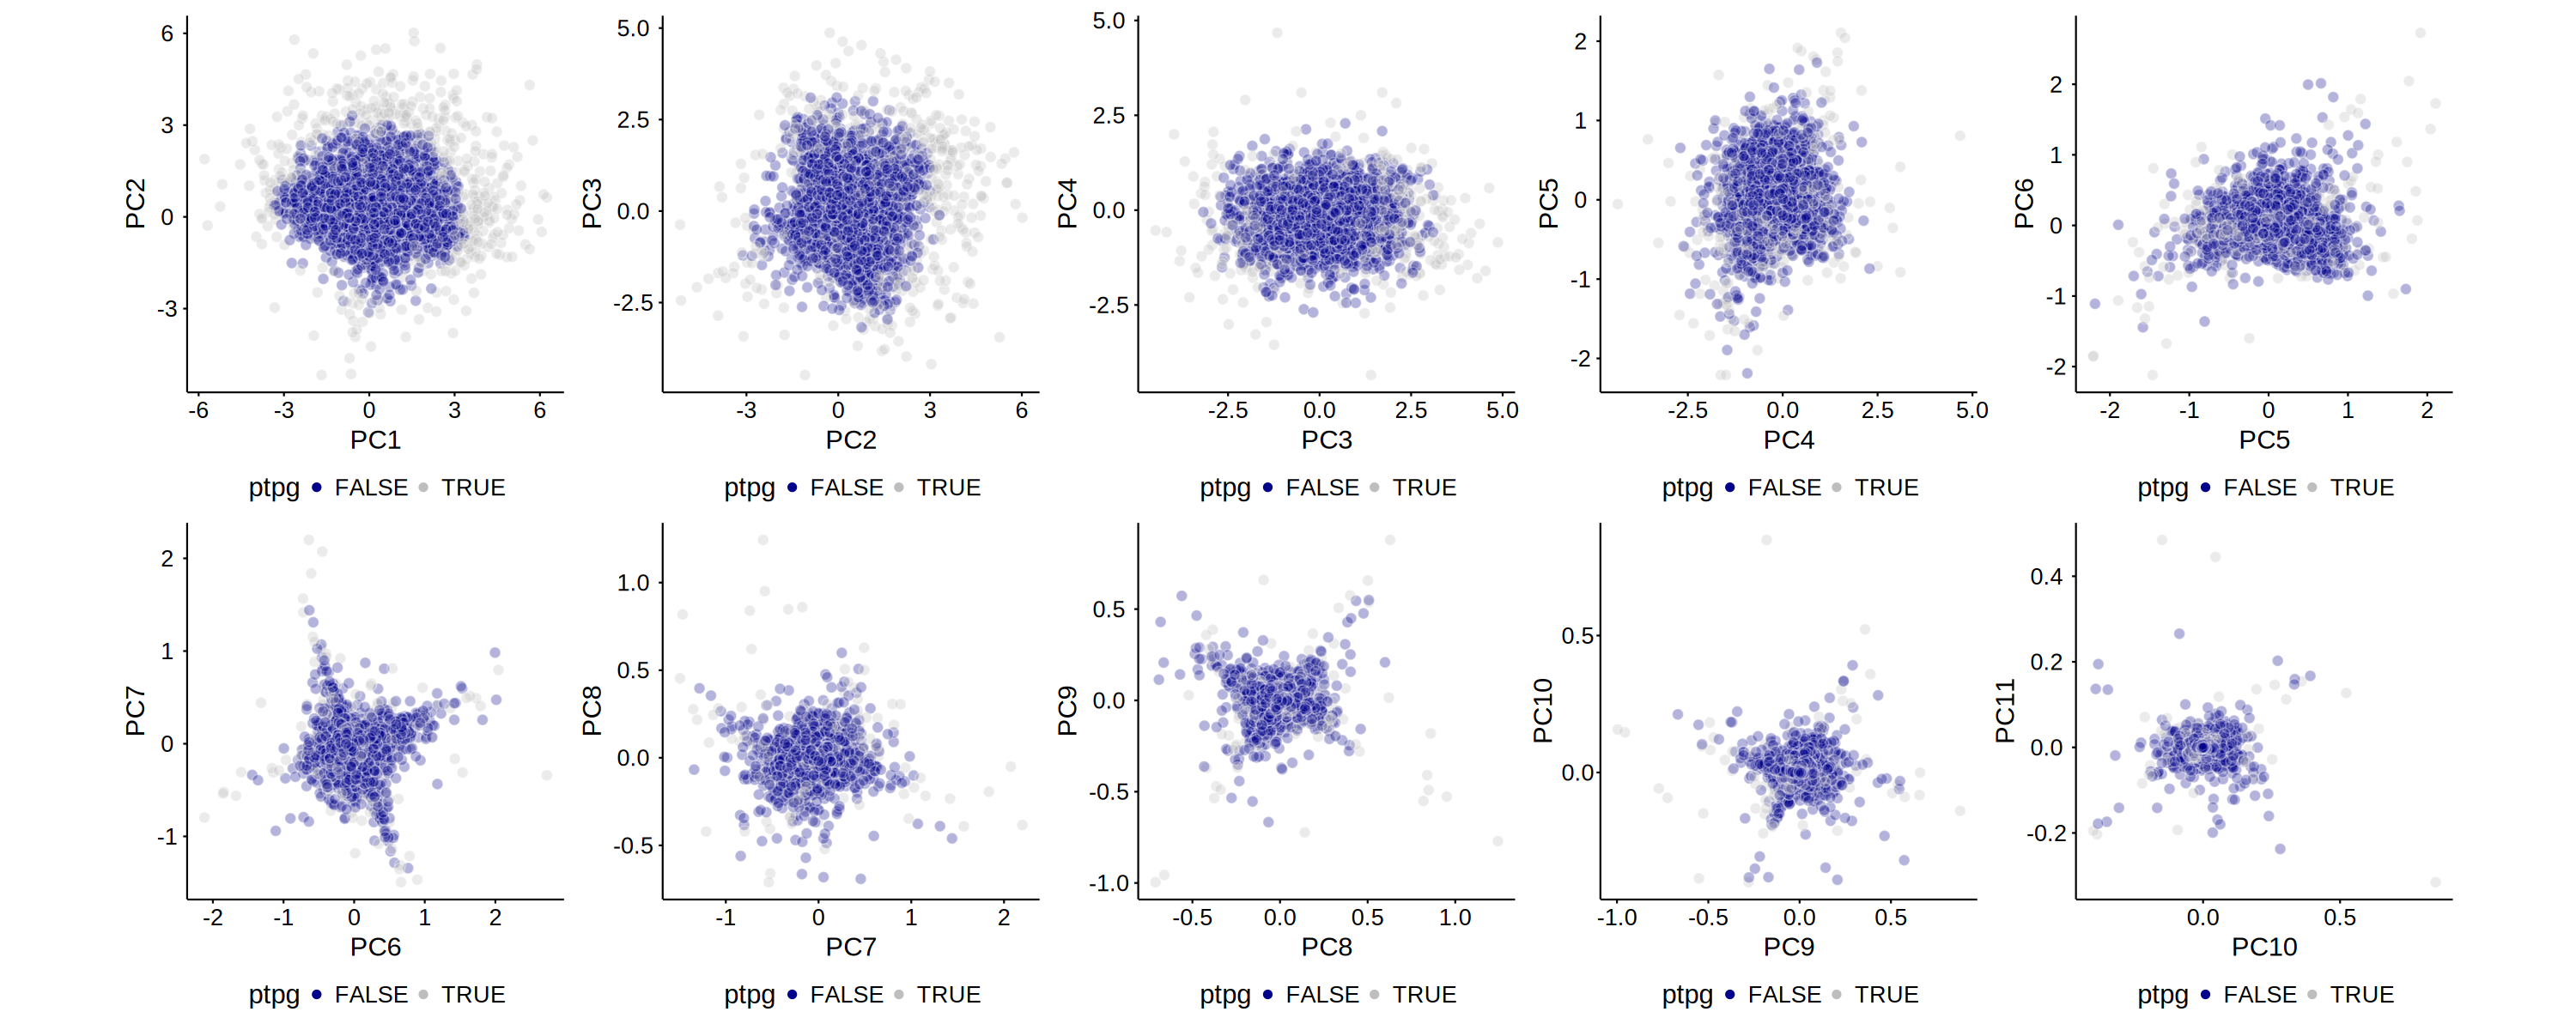

In [158]:
options(repr.plot.width=5*5, repr.plot.height=10)

wrap_plots(pca_plot_ptag, ncol=5, nrow=2)

# Cluster PTCG, PTPG, PTUG 

In [159]:
cnt_scale_ptcg <- cnt_scale_ptag[ptpg[!ptpg$ptpg, ]$gene, ]

dist_ptcg <- parallelDist::parDist(cnt_scale_ptcg, method=dist_method)
hclust_ptcg <- hclust(dist_ptcg, hclust_method)

In [160]:
cnt_scale_ptpg <- cnt_scale_ptag[ptpg[ptpg$ptpg, ]$gene, ]

dist_ptpg <- parallelDist::parDist(cnt_scale_ptpg, method=dist_method)
hclust_ptpg <- hclust(dist_ptpg, hclust_method)

In [163]:
k_ptcg <- 6
k_ptpg <- 6

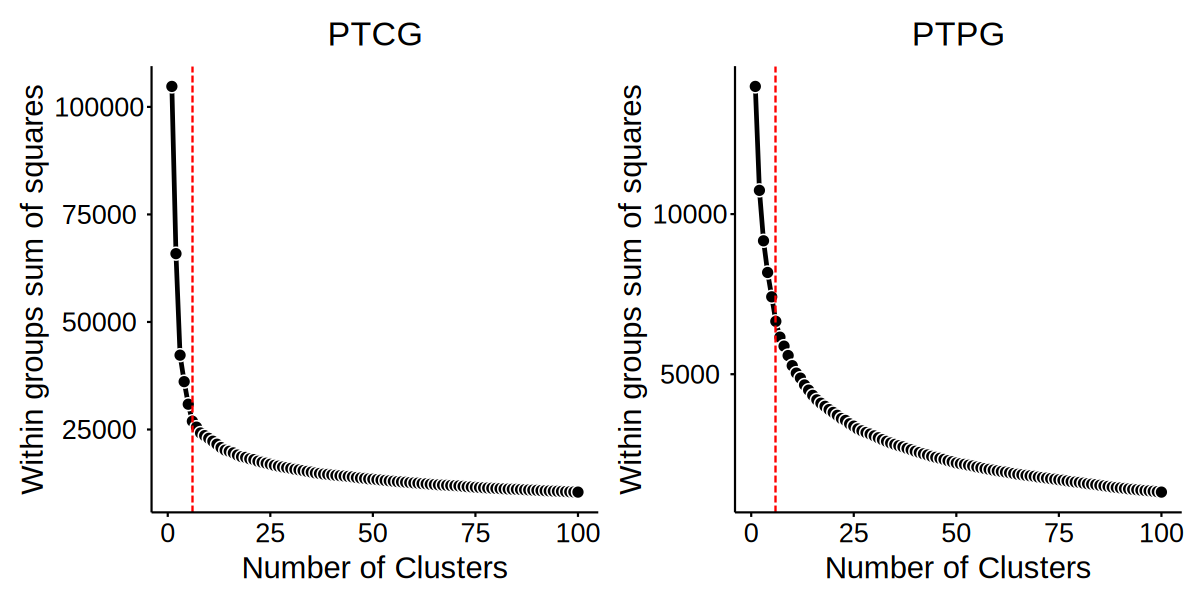

In [164]:
options(repr.plot.width=10, repr.plot.height=5)

elbow_wcss_plot(cnt_scale_ptcg, hclust_ptcg, 100, k_ptcg, title="PTCG") + 
elbow_wcss_plot(cnt_scale_ptpg, hclust_ptpg, 100, k_ptpg, title="PTPG") + 
patchwork::plot_layout(ncol=2)

## Plot cluster genes 

In [165]:
cluster_plot <- function(cnt_scale, cluster, cluster_filter=NULL, prototype=FALSE) {
    
    cluster_label <- cluster
    cluster_label_unique <- unique(cluster_label)[order(unique(cluster_label))]
    
    if(!is.null(cluster_filter)) {cluster_label_unique <- cluster_filter}
    
    cnt_scale <- as.data.frame(cnt_scale)
    
    p_list <- list()
    for(cluster_label_i in cluster_label_unique) {
        
        data <- cnt_scale[which(cluster_label==cluster_label_i), ]
        data <- reshape2::melt(rownames_to_column(data, var="gene"), id="gene")

        data$condition <- as.character(sapply(strsplit(as.character(data$variable), ":"), `[`, 2))
        data$pseudotime <- as.double(sapply(strsplit(as.character(data$variable), ":"), `[`, 3))
        
        if(prototype) {
            
            suppressMessages(data <- dplyr::group_by(data, pseudotime, condition) %>% dplyr::summarise(value=mean(value)))
            p <- ggplot(data, aes(x=pseudotime, y=value, color=condition, group=paste(condition))) + geom_line(size=3, alpha=1)
            
        } else {
            
            p <- ggplot(data, aes(x=pseudotime, y=value, color=condition, group=paste(condition, gene))) + geom_line(size=1, alpha=1)
            
        }
        
        p_list[[paste("Cluster", cluster_label_i)]] <- p +  
            ylim(-ceiling(max(abs(data$value))), ceiling(max(abs(data$value)))) + 
            geom_hline(yintercept=0, linetype="dashed") + 
            ggtitle(paste("Cluster", cluster_label_i)) + 
            scale_color_manual(values=unlist(color$infection)) + 
            theme(legend.position="bottom")
        
    }
    
    return(p_list)
    
}

In [166]:
hm_pt_cluster_smooth <- function(fitgam, cluster, cluster_order=NULL, condition_test=NULL, n, width=1.0, height=0.005, user_raster=FALSE, column_title=NULL, use_raster=FALSE) {

    # Set genes and cluster 
    genes <- names(cluster)
    cluster <- as.character(cluster)
    
    # Set cluster order 
    if(!is.null(cluster_order)) {cluster <- factor(cluster, levels=cluster_order)}
    
    # Get smoothed data
    mat <- predictSmooth(fitgam, gene=genes, nPoints=n, tidy=FALSE) 
    mat <- mat[genes, ]
    mat <- t(apply(mat, 1, scales::rescale))
    
    # Color mat
    breaks_mat <- seq(0, 1, length.out=4)
    color_function_mat <- viridis::mako(length(breaks_mat))
    
    # Column annotation 
    top_annotation <- HeatmapAnnotation(

        df=data.frame(infection=factor(c(rep("Baseline", n), rep("CpG", n)), levels=c("Baseline", "CpG"))), 
        col=list(infection=unlist(color$infection)), 
        simple_anno_size=unit(6, "mm"), 
        show_annotation_name=FALSE, 
        show_legend=FALSE

    )
    
    
   
    hm_1 <- Heatmap(

        matrix=mat, 

        col=color_function_mat, 
        na_col="white", 

        width=n*unit(width, "mm"),
        height=unit(163, "mm"),

        # row_title=NULL, 
        row_title_gp=gpar(fontsize=18, fontface="bold"), 

        column_title=column_title, 
        column_title_gp=gpar(fontsize=18, fontface="bold"), 

        row_names_gp=gpar(fontsize=16, fontface="plain"), 
        column_names_gp=gpar(fontsize=18, fontface="plain"), 

        cluster_rows=TRUE, 
        cluster_row_slices=FALSE, 
        show_row_dend=FALSE,   
        row_split=cluster, 
        row_gap=unit(2, "mm"),
        show_row_names=FALSE,
        row_names_side="right",

        cluster_columns=FALSE,
        cluster_column_slices=FALSE, 
        show_column_dend=FALSE, 
        column_split=factor(c(rep("Baseline", n), rep("CpG", n)), levels=c("Baseline", "CpG")), ,
        column_gap=unit(2, "mm"), 
        show_column_names=FALSE, 

        top_annotation=top_annotation, 
        right_annotation=NULL, 

        rect_gp=gpar(col=NA, lwd=0, alpha=1), 

        heatmap_legend_param=list(title="Expression", title_gp=gpar(fontsize=18, fontface="plain"), labels_gp=gpar(fontsize=16), legend_height=unit(5*6, "mm"), grid_width=unit(6, "mm")), 

        border=FALSE, 
        border_gp=gpar(col="black", lwd=unit(0.5, "mm")), 

        use_raster=use_raster, 
        
        raster_resize_mat=mean

    )
    
    
    return(hm_1)  
    
    
}

## Cluster genes PTCG 

In [182]:
cluster_genes_ptcg <- cluster_plot(cnt_scale_ptcg, cutree(hclust_ptcg, k_ptcg), prototype=TRUE)

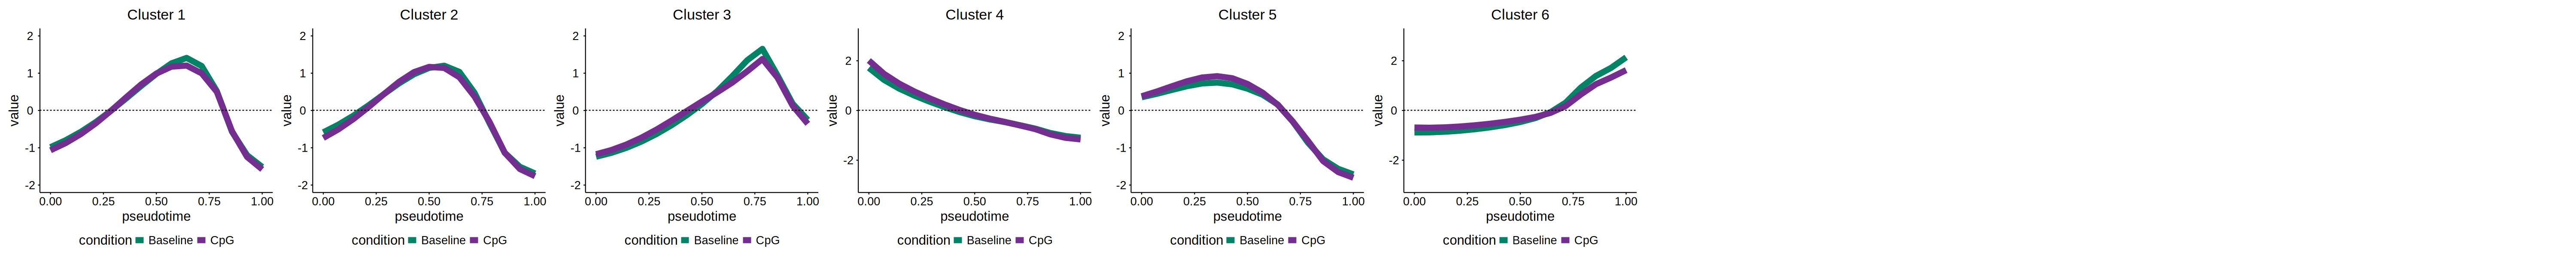

In [183]:
options(repr.plot.width=10*5, repr.plot.height=ceiling(length(cluster_genes_ptcg)/10)*5)
wrap_plots(cluster_genes_ptcg, ncol=10, nrow=ceiling(length(cluster_genes_ptcg)/10))

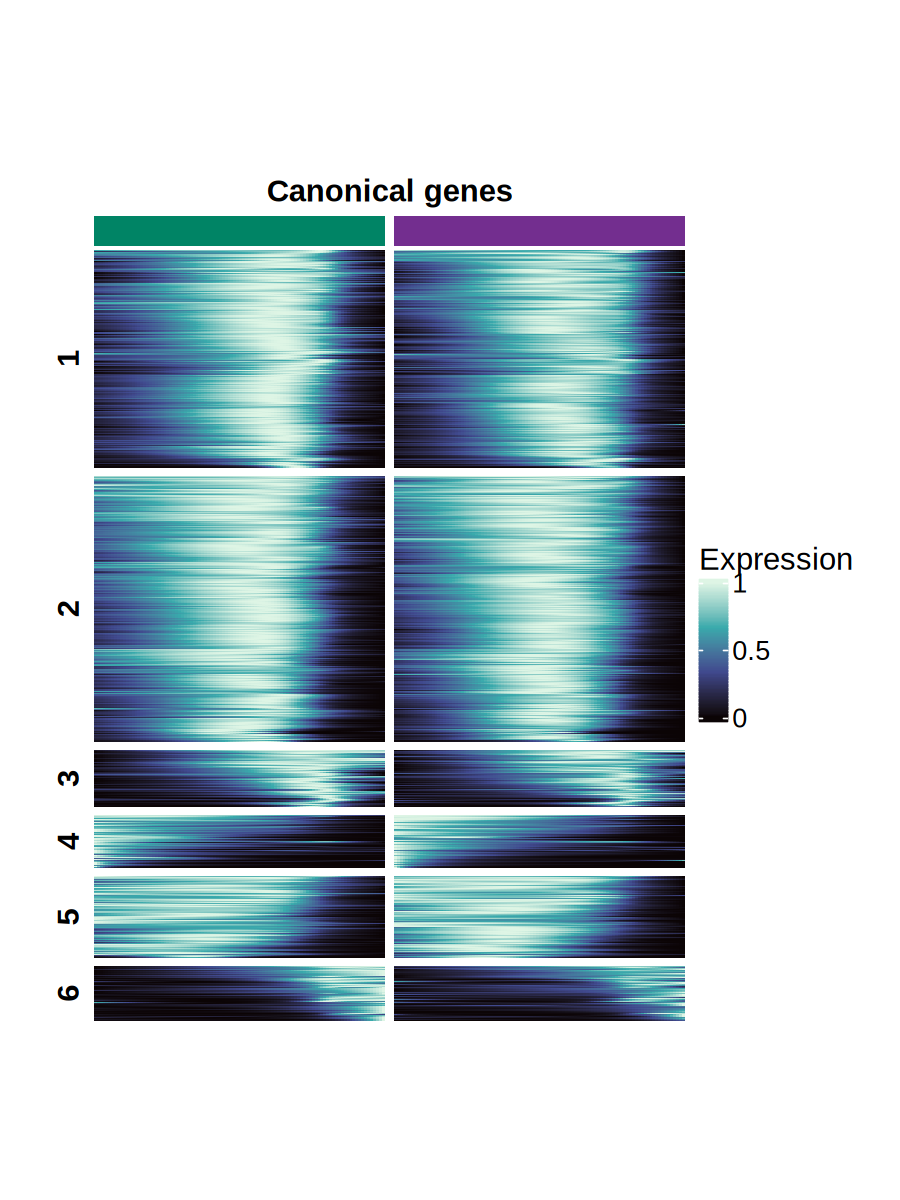

In [190]:
options(repr.plot.width=7.5, repr.plot.height=10)

n <- 100

hm_ptag <- hm_pt_cluster_smooth(tradeseq_eb[["fitgam"]], cluster=cutree(hclust_ptcg, k_ptcg), cluster_order=as.character(1:10), n=n, width=2.5*(50/n), height=0.075, column_title="Canonical genes")
hm_ptag

In [185]:
pdf(file="result/figures/hm_ptag_ery.pdf", width=unit(20, "cm"), height=unit(20, "cm"))

hm_ptag <- hm_pt_cluster_smooth(tradeseq_eb[["fitgam"]], cluster=cutree(hclust_ptcg, k_ptcg), cluster_order=as.character(1:k_ptcg), n=100, width=2.5*(50/100), height=0.075, column_title="Canonical genes", use_raster=TRUE)
hm_ptag

dev.off()

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



pdf 
  2

## Cluster genes PTPG

In [186]:
cluster_genes_ptpg <- cluster_plot(cnt_scale_ptpg, cutree(hclust_ptpg, k_ptpg), prototype=TRUE)

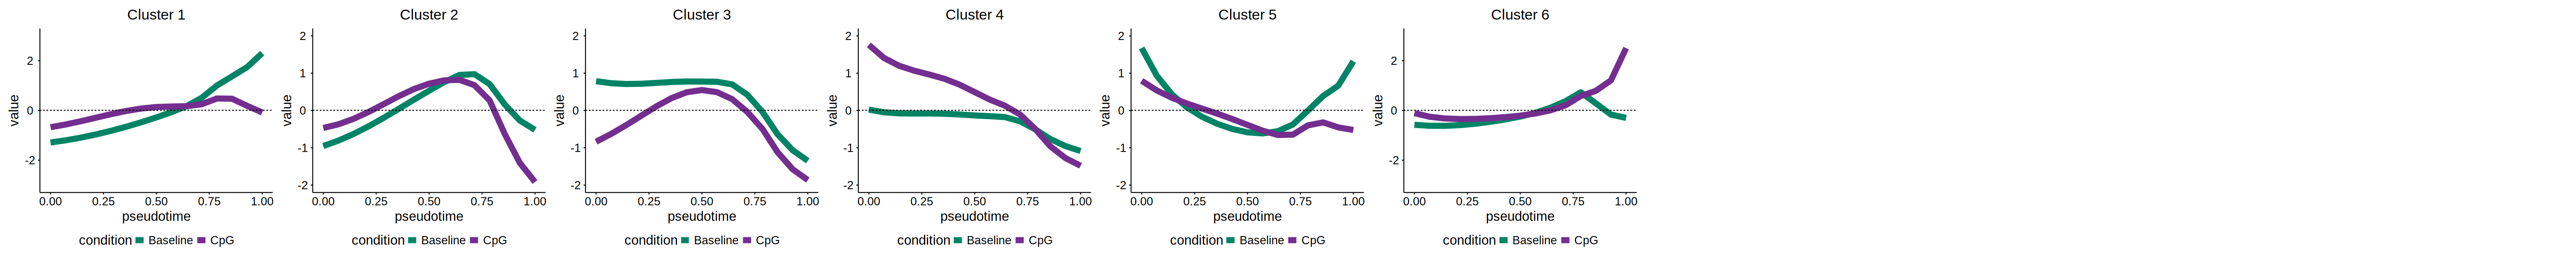

In [187]:
options(repr.plot.width=10*5, repr.plot.height=ceiling(length(cluster_genes_ptpg)/10)*5)
wrap_plots(cluster_genes_ptpg, ncol=10, nrow=ceiling(length(cluster_genes_ptpg)/10))

In [173]:
options(repr.plot.width=3*7.5, repr.plot.height=10)

hm_ptag_1 <- hm_pt_cluster_smooth(tradeseq_eb[["fitgam"]], cluster=cutree(hclust_ptpg, k_ptpg)[cutree(hclust_ptpg, k_ptpg) %in% 1:10], cluster_order=as.character(1:10), n=100, width=2.5*(50/100), height=0.25, column_title="Perturbed genes")
# hm_ptag_2 <- hm_pt_cluster_smooth(tradeseq_eb[["fitgam"]], cluster=cutree(hclust_ptpg, k_ptpg)[cutree(hclust_ptpg, k_ptpg) %in% 11:20], cluster_order=as.character(11:20), n=100, width=2.5*(50/100), height=0.25, column_title="Perturbed genes")
# hm_ptag_3 <- hm_pt_cluster_smooth(tradeseq_eb[["fitgam"]], cluster=cutree(hclust_ptpg, k_ptpg)[cutree(hclust_ptpg, k_ptpg) %in% 21:30], cluster_order=as.character(21:30), n=100, width=2.5*(50/100), height=0.25, column_title="Perturbed genes") 

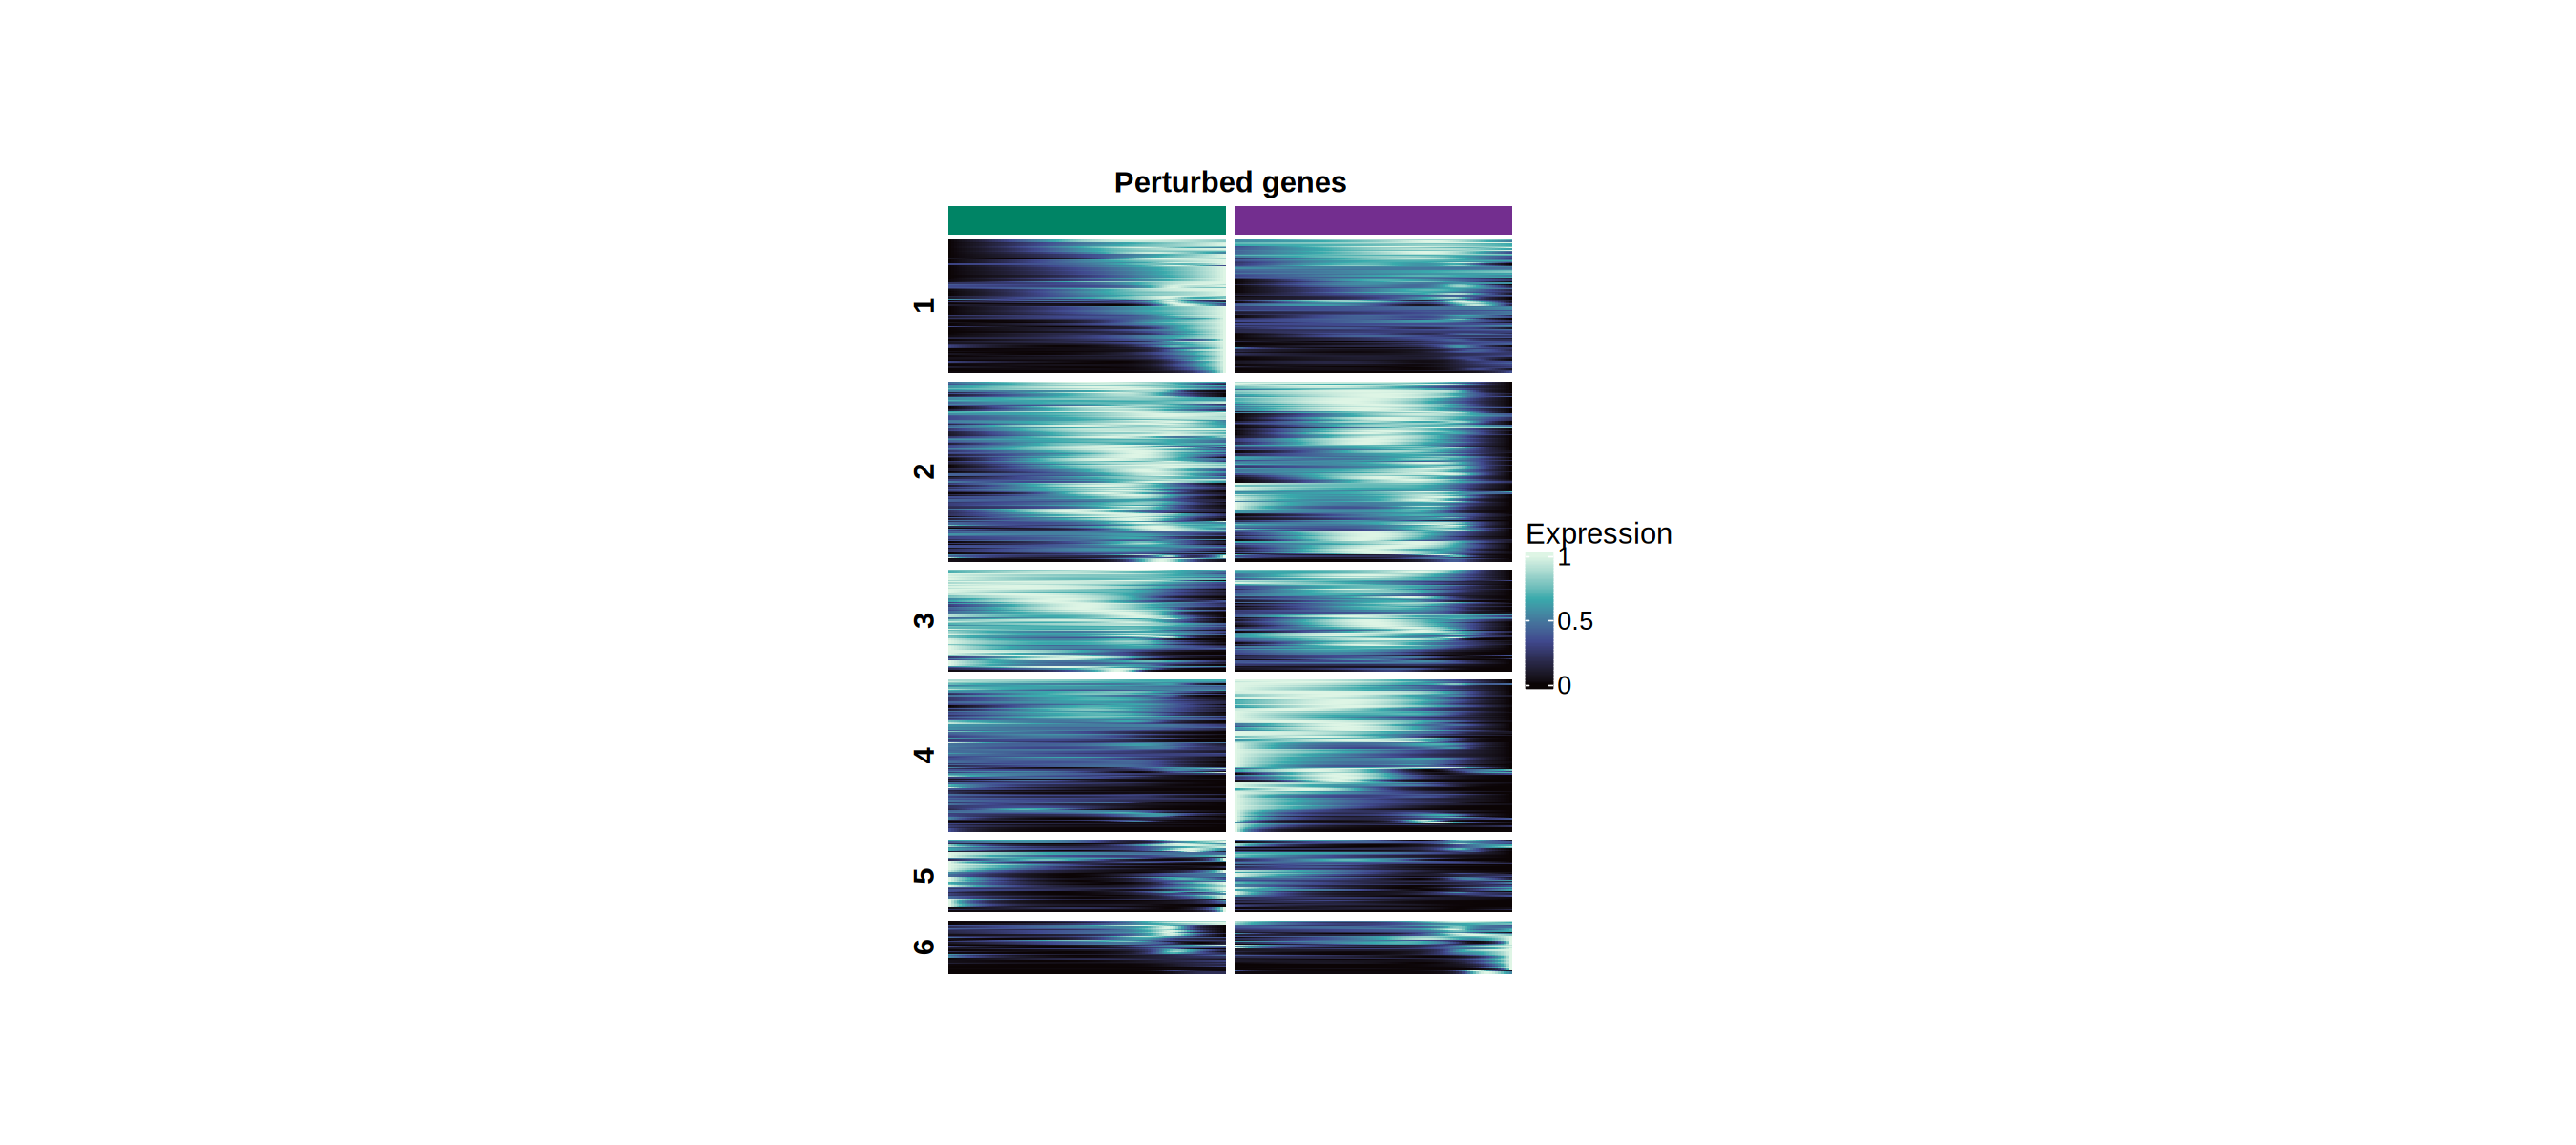

In [174]:
as.ggplot(hm_ptag_1)
# as.ggplot(hm_ptag_1) + as.ggplot(hm_ptag_2) + as.ggplot(hm_ptag_3)

$`1`

$`2`


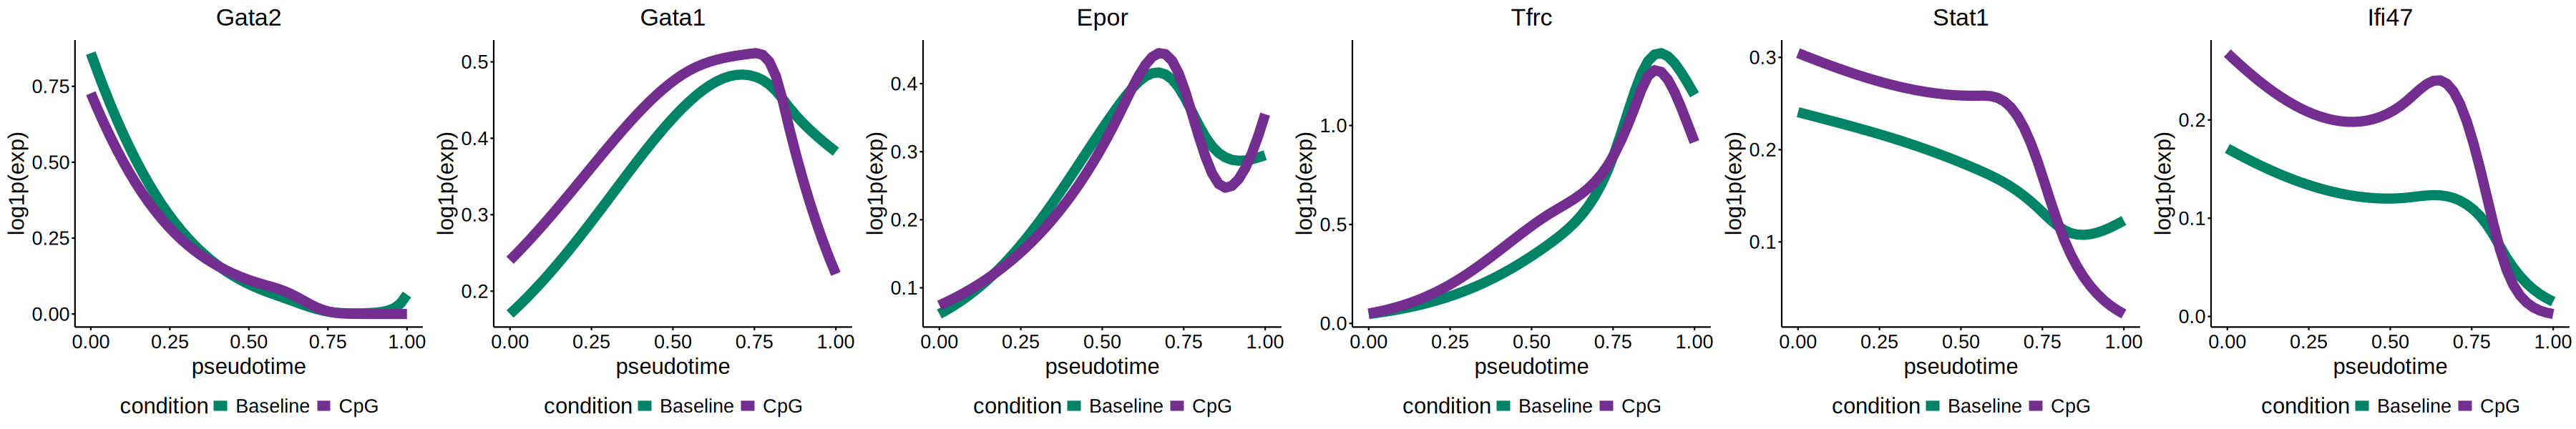


attr(,"class")
[1] "list"      "ggarrange"


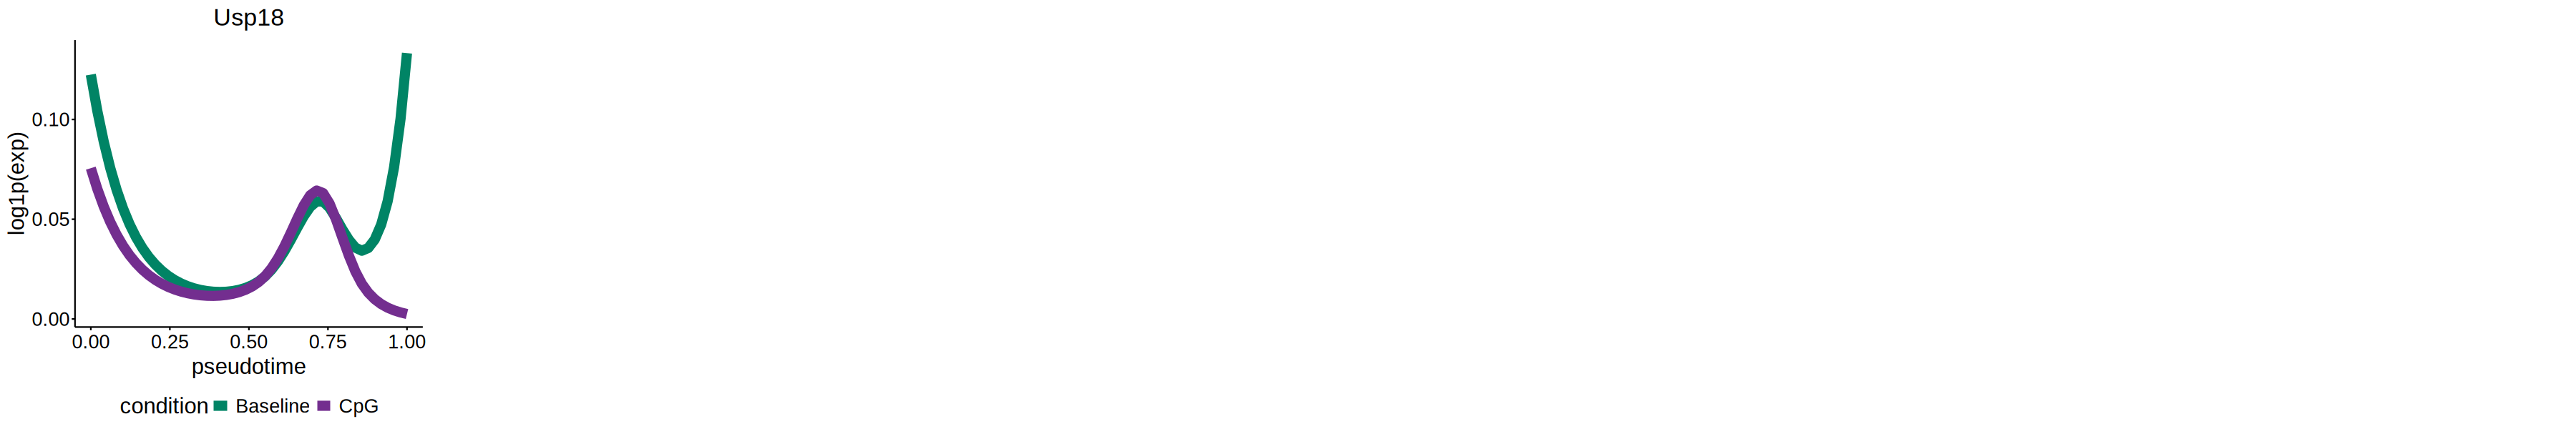

In [175]:
options(repr.plot.width=6*5, repr.plot.height=5)
source("bin/tradeseq.R")
p_1 <- list(
    
    plot_smooth(tradeseq_eb[["fitgam"]], gene="Gata2", point=FALSE), 
    plot_smooth(tradeseq_eb[["fitgam"]], gene="Gata1", point=FALSE), 
    plot_smooth(tradeseq_eb[["fitgam"]], gene="Epor", point=FALSE), 
    plot_smooth(tradeseq_eb[["fitgam"]], gene="Tfrc", point=FALSE), 
    plot_smooth(tradeseq_eb[["fitgam"]], gene="Stat1", point=FALSE), 
    plot_smooth(tradeseq_eb[["fitgam"]], gene="Ifi47", point=FALSE), 
    plot_smooth(tradeseq_eb[["fitgam"]], gene="Usp18", point=FALSE)
    
)

ggpubr::ggarrange(plotlist=p_1, ncol=6, common.legend=FALSE, legend="bottom") %>% print()

# Cluster over representation analysis (ORA)

In [176]:
ora_plot <- function(ora, pval_thr=0.05, title="", pathway_suffix=NULL, pathway_filter=NULL, scale_size=2, top=10) {
    
    ora <- as.data.frame(ora)
    
    ora$sig_class <- ifelse(ora$pval<=pval_thr, paste0("pval<=", pval_thr), NA)

    ora$minus_log_pval <- -log10(ora$pval)
    ora <- arrange(ora, pval)[1:top, ]

    if(!is.null(pathway_filter)) {ora <- ora[ora$pathway %in% pathway_filter, ]}
    if(!is.null(pathway_suffix)) {ora$pathway <- gsub(pathway_suffix, "", ora$pathway)}
    ora$pathway <- gsub("_", " ", ora$pathway)
    
    # Order hits 
    ora$pathway <- factor(ora$pathway, levels=rev(ora$pathway))

    x_max <- max(ora$minus_log_pval)
    
    plot <- ggplot(ora, aes(x=minus_log_pval, y=pathway, title=title, size=abs(NES), color=sig_class)) + 
        geom_point() + 
        ggtitle(title) + xlab("-log10(pval.)") + ylab("") +
        scale_x_continuous(expand=c(0.1, 0.1)) + 
        scale_y_discrete(expand=c(0, 1)) + 
        scale_color_manual(values=brewer.pal(11,"RdBu")[2], na.value="grey") + 
        scale_size(range=c(0, scale_size)) + 
        guides(
            
            color=guide_legend(title="Significance", keywidth=0.75, keyheight=0.75), 
            size=guide_legend(order=2, title="Abs. (NES)", keywidth=0.75, keyheight=0.75)
        
        ) + 
    
        theme(axis.text.y=element_text(hjust=1, vjust=0.5))
    
    return(plot)
    
}

In [177]:
ora_cluster <- function(hclust, k, universe=genes_ptag, category="H", subcategory=NULL) {
    
    # Get gene set
    gene_set <- msigdbr(species="Mus musculus", category=category, subcategory=subcategory)
    gene_set <- split(gene_set, x=gene_set$gene_symbol, f=gene_set$gs_name)
    
    cluster_label <- cutree(hclust, k)
    cluster_label_unique <- unique(cluster_label)[order(unique(cluster_label))]
    
    ora_plot_list <- list()
    for(i in cluster_label_unique) {

        ora_result <- fora(

            pathways=gene_set, 
            genes=names(which(cluster_label==i)),
            universe=universe,
            minSize=5, 
            maxSize=Inf

        )

        ora_result$NES <- ora_result$size
        
        ora_plot_list[[i]] <- ora_plot(ora_result, pval_thr=0.05, title="", pathway_suffix="GOBP|GOCC|GOMF|REACTOME|KEGG|HALLMARK|BIOCARTA|PID|WP", pathway_filter=NULL, scale_size=5, top=15) + ggtitle(paste("Cluster", i))

    }
    
    return(ora_plot_list)
    
    
}

## ORA PTCG 

In [178]:
ora_cluster_ptcg <- ora_cluster(hclust_ptcg, k_ptcg, universe=genes_ptag)

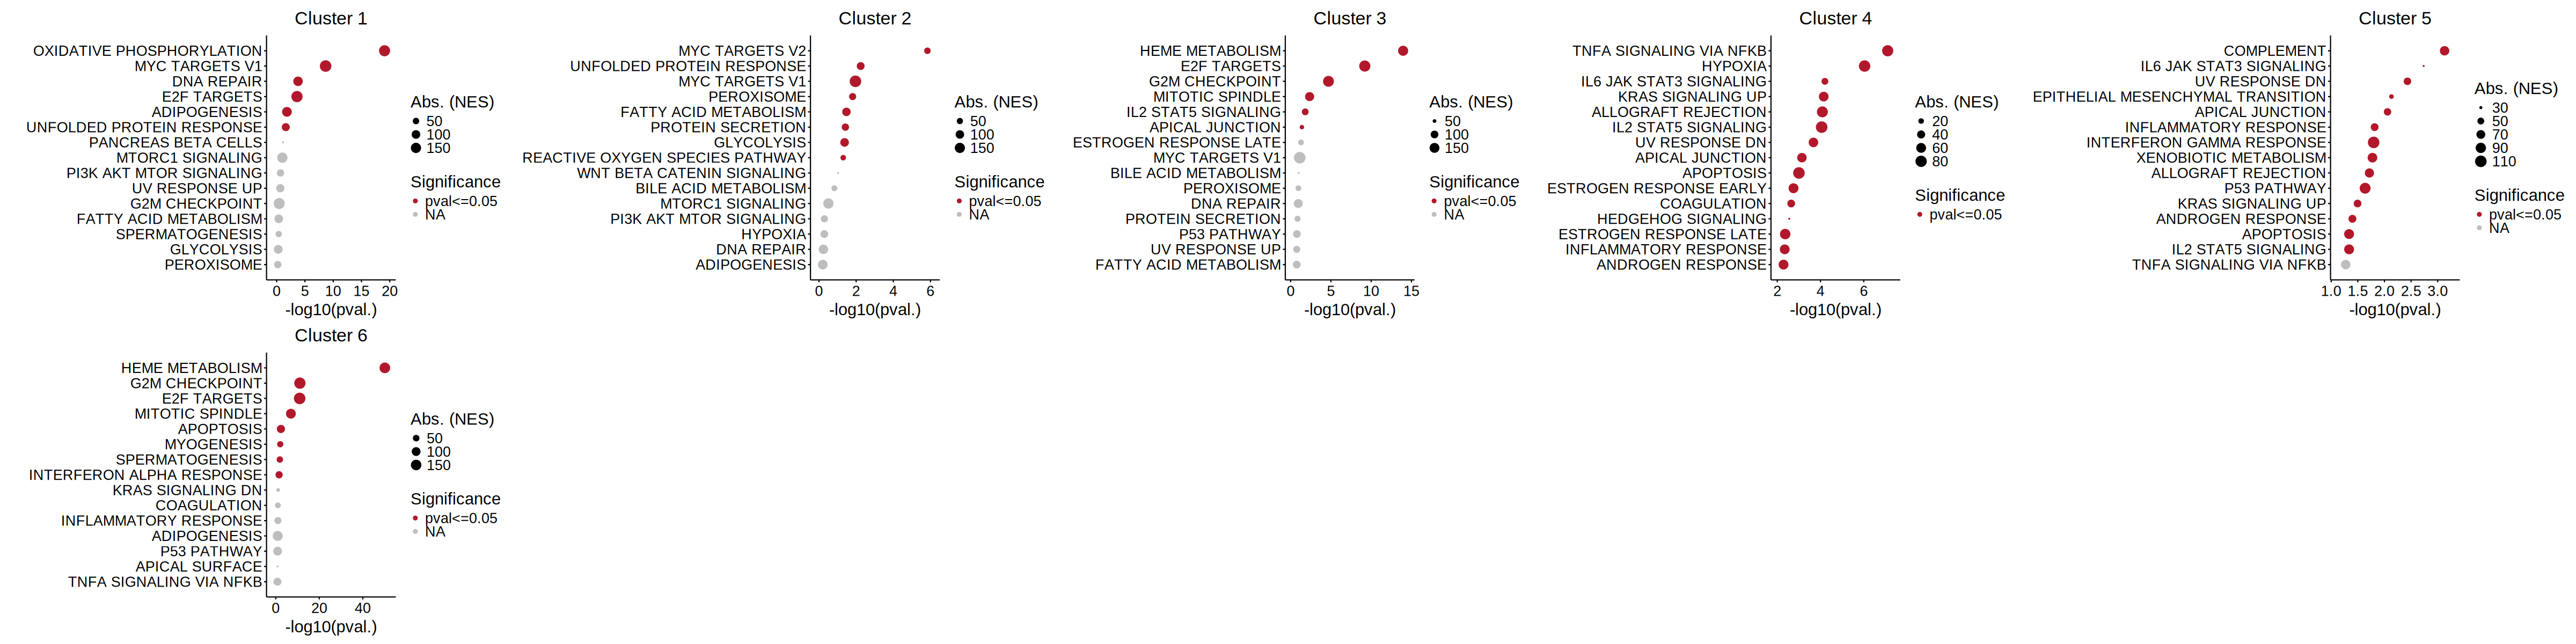

In [179]:
options(repr.plot.width=8*5, repr.plot.height=ceiling(length(ora_cluster_ptcg)/5)*5)
wrap_plots(ora_cluster_ptcg, ncol=5, nrow=ceiling(length(ora_cluster_ptcg)/5))

## ORA PTPG 

In [180]:
ora_cluster_ptpg <- ora_cluster(hclust_ptpg, k_ptpg, universe=genes_ptag)

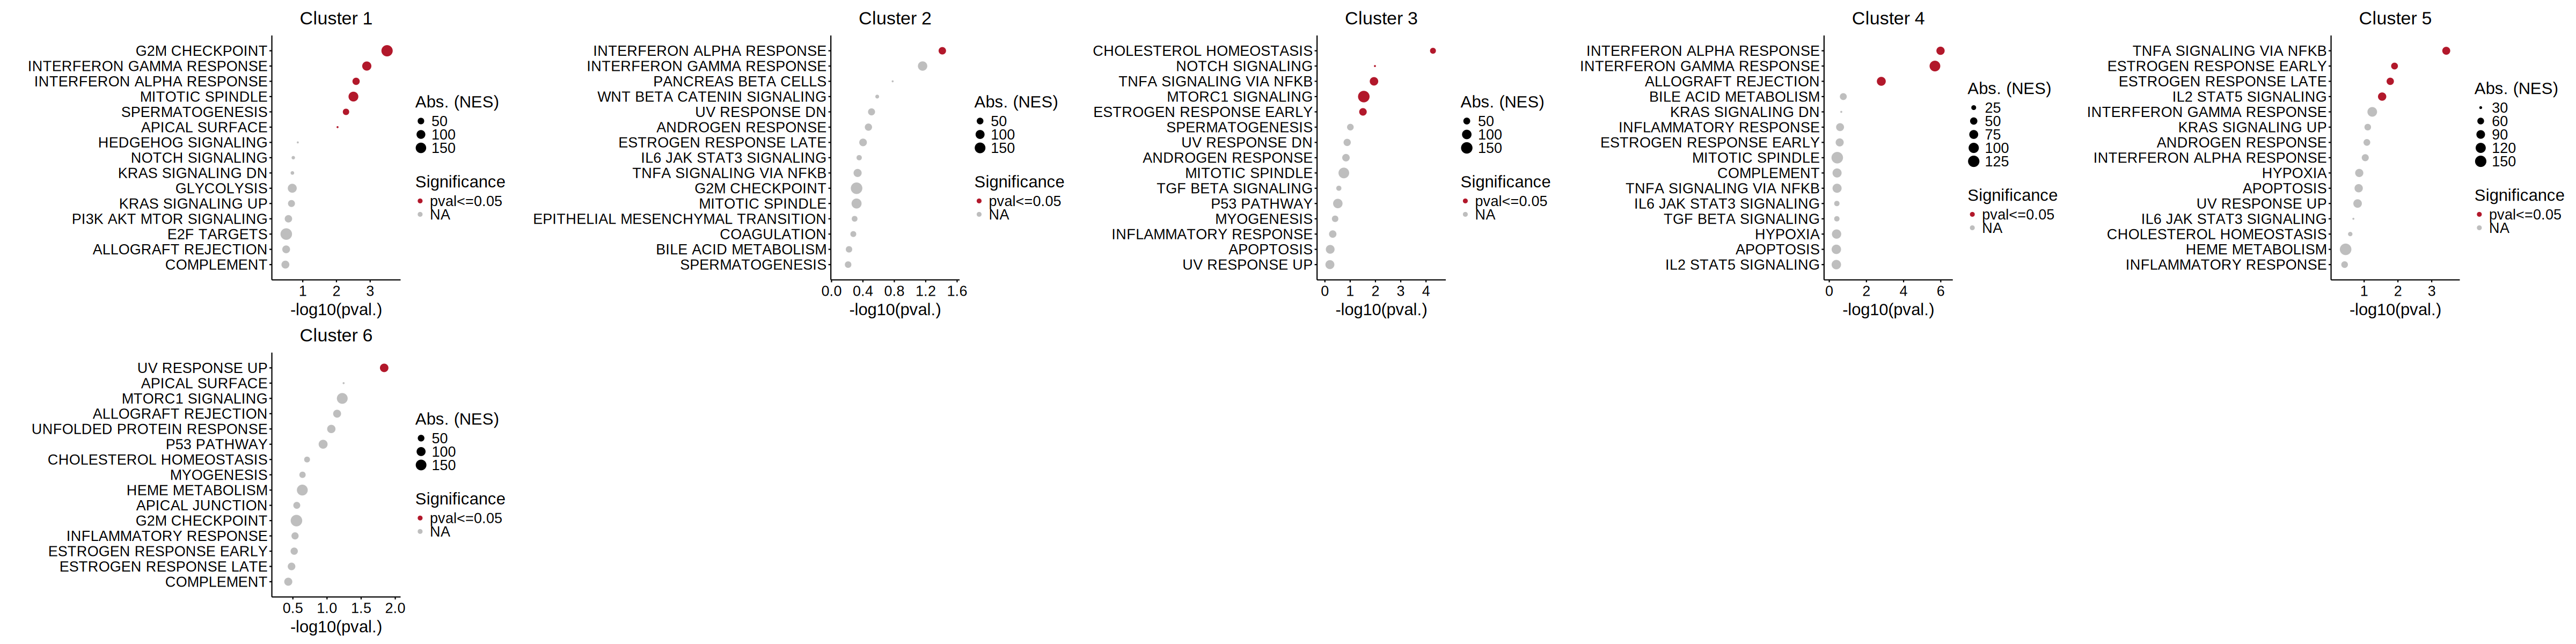

In [181]:
options(repr.plot.width=8*5, repr.plot.height=ceiling(length(ora_cluster_ptpg)/5)*5)
wrap_plots(ora_cluster_ptpg, ncol=5, nrow=ceiling(length(ora_cluster_ptpg)/5))